In [1]:
from os import path
from pyprojroot import here
workspace_path = '/Users/seyongpark/Projects/gravitational-lensing'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt
import matplotlib.pylab as plt
from astropy.cosmology import FlatLambdaCDM
import numpy as np
import shapely
from shapely import Polygon, Point, points
from shapely.prepared import prep
from scipy import ndimage
from tqdm.contrib.concurrent import thread_map

/Users/seyongpark/Projects/gravitational-lensing
Working Directory has been set to `/Users/seyongpark/Projects/gravitational-lensing`


In [3]:

def transform_image(image,angle,center,scale):
    pixel_shift = np.array([center[0],center[1]])/scale
    transformed_image = image.native
    transformed_image = ndimage.rotate(transformed_image,angle,order=0,reshape=False)
    transformed_image = ndimage.shift(transformed_image,pixel_shift,order=0)    
    # return al.Array2D.no_mask(transformed_image,pixel_scales=scale)
    return transformed_image

def plot_image(image,center,fov,ax,title,**kwargs):
    #ax.contourf(X+0.02187,Y+7.52,magnif.native,levels=[70,100000],zorder=10)
    x_center = center[1]
    y_center = center[0]
    im = ax.imshow(
    np.log10(
        image,
        where=(image != 0),
        out=np.full_like(image, -15),
    )+6,
    extent=[
         x_center - fov / 2,
         x_center + fov / 2,
         y_center - fov / 2,
         y_center + fov / 2,
     ],
    cmap="inferno",
    vmin=-5,
    vmax=-1,
    **kwargs)
    ax.set(
    xlabel="arcsec", ylabel="arcsec"
    )
    # ax.set(xlabel='arcsec ({:.2f} " / pixel)'.format(detector_arcsec_per_pxl), ylabel="arcsec")
    ax.set_facecolor("black")
    ax.set_title(title)
    return im

## Source Image

In [4]:
image_path = path.join("new2.fits")

zoom = 1

# read in source image data
galaxy_image = al.Array2D.from_fits(
    file_path=image_path,
    pixel_scales=0.0001*zoom,
)
galaxy_image_native = galaxy_image.native

source_center = (-7.521, 0.022)
#source_center = (-7.8,0.3)
source_pix = galaxy_image.shape_native[0]
source_fov = source_pix*galaxy_image.pixel_scale

# define source plane
source_plane = al.Grid2D.uniform(
    shape_native=galaxy_image.shape_native,
    pixel_scales=galaxy_image.pixel_scale,
    origin=source_center
)
source_plane_native = source_plane.native
source_y_range = [source_center[0]-source_fov/2,source_center[0]+source_fov/2]
source_x_range = [source_center[1]-source_fov/2,source_center[1]+source_fov/2]

source_plane_box = Polygon(([source_x_range[0],source_y_range[0]],[source_x_range[1],source_y_range[0]],
                            [source_x_range[1],source_y_range[1]],[source_x_range[0],source_y_range[1]]))

galaxy_image_grid = np.stack((source_plane.native[:,:,0],source_plane.native[:,:,1],galaxy_image.native))
galaxy_image_grid = np.swapaxes(galaxy_image_grid,0,2)
galaxy_image_grid = np.swapaxes(galaxy_image_grid,0,1)

In [4]:
source_plane.native.shape

(1000, 1000, 2)

## Image Plane

In [5]:
image_center = (-29.2,25)
detector_arcsec_per_pxl = 0.03
reco_image_fov = 20  # arcsec on one side
image_pix = int(reco_image_fov / detector_arcsec_per_pxl)

image_plane_centers = al.Grid2D.uniform(
    shape_native=(image_pix, image_pix),
    pixel_scales=detector_arcsec_per_pxl,
    origin=image_center
)

image_plane_corners = al.Grid2D.uniform(
    shape_native=(image_pix+1, image_pix+1),
    pixel_scales=detector_arcsec_per_pxl,
    origin=image_center
)

## Ray Tracing

In [6]:
# compute scaling ratio for deflection angles
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

D_ds = cosmo.angular_diameter_distance_z1z2(0.566,6.2) # distance from source to lens
D_s = cosmo.angular_diameter_distance_z1z2(0,6.2) # distance to source
ratio = D_ds/D_s

# paths for deflection data
x_path = path.join("glafic-model","hlsp_relics_model_model_whl0137-08_glafic_v1_x-arcsec-deflect.fits")
y_path = path.join("glafic-model","hlsp_relics_model_model_whl0137-08_glafic_v1_y-arcsec-deflect.fits")

scale = 0.1 # computed from comparing pixel and arcsec files

# read in deflection data
deflections_y = al.Array2D.from_fits(
    file_path=y_path,
    pixel_scales=scale,
)
deflections_x = al.Array2D.from_fits(
    file_path=x_path,
    pixel_scales=scale,
)

# scale deflection angles to account for redshift
deflections_y = al.Array2D.no_mask(ratio*deflections_y.native,
                                   pixel_scales = scale)
deflections_x = al.Array2D.no_mask(ratio*deflections_x.native,
                                   pixel_scales = scale)

# construct mass profile using deflections
deflections_plane_grid_2d = al.Grid2D.uniform(
    shape_native=deflections_y.shape_native,
    pixel_scales=scale,  # The pixel-scale describes the conversion from pixel units to arc-seconds
)
input_deflections = al.mp.InputDeflections(
    deflections_y=deflections_y,
    deflections_x=deflections_x,
    image_plane_grid=deflections_plane_grid_2d
)

In [5]:
deflections_y.native.shape

(1200, 1200)

In [7]:
# define lens, source and tracer
lens_galaxy = al.Galaxy(redshift=0.566, mass=input_deflections)
source_galaxy = al.Galaxy(redshift=6.2)
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

# trace image plane to source plane
traced_image_plane_corners = tracer.traced_grid_2d_list_from(grid=image_plane_corners)[1]
traced_image_plane_corners_native = traced_image_plane_corners.native

In [21]:
galaxy_center = (-0.005,0.005)
#galaxy_center = (0,0)
galaxy_angle = -70

# rotate and shift image
transformed_galaxy = transform_image(galaxy_image, galaxy_angle, galaxy_center, galaxy_image.pixel_scale)

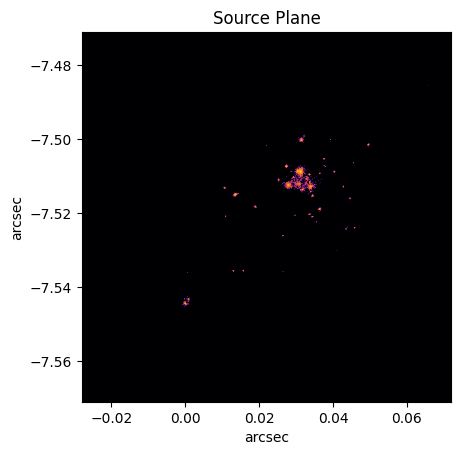

In [22]:
fig, ax = plt.subplots()
plot_image(transformed_galaxy, source_center, source_fov, ax, "Source Plane")

In [23]:
from itertools import product
import multiprocess as mp

y = source_plane.native[:,0,0]
x = source_plane.native[0,:,1]

def luminosity(index):
    i, j = index
    top_left = traced_image_plane_corners_native[i,j]
    top_right = traced_image_plane_corners_native[i+1,j]
    bottom_right = traced_image_plane_corners_native[i+1,j+1]
    bottom_left = traced_image_plane_corners_native[i,j+1]

    vertices = [top_left,top_right,bottom_right,bottom_left]

    traced_pixel = prep(Polygon(vertices))

    # compute bounding box
    x_min = min([v[1] for v in vertices])
    y_min = min([v[0] for v in vertices])
    x_max = max([v[1] for v in vertices])
    y_max = max([v[0] for v in vertices])

    y_index_range = [np.where(y-y_max > 0, y-y_max, np.inf).argmin(),np.where(y_min-y > 0, y_min-y, np.inf).argmin()]
    x_index_range = [np.where(x_min-x > 0, x_min-x, np.inf).argmin(),np.where(x-x_max > 0, x-x_max, np.inf).argmin()]

    image_slice = transformed_galaxy[y_index_range[0]:y_index_range[1]+1,x_index_range[0]:x_index_range[1]+1]
    if image_slice.size == 0:
        return 0
    else:
        source_plane_slice = source_plane_native[y_index_range[0]:y_index_range[1]+1,x_index_range[0]:x_index_range[1]+1]
        source_points = np.stack((source_plane_slice[:,:,0],source_plane_slice[:,:,1],image_slice))
        source_points = np.swapaxes(source_points,0,2)
        source_points = np.swapaxes(source_points,0,1)
        source_points = shapely.points(np.concatenate(source_points))

        source_pixels = []
        source_pixels.extend(filter(traced_pixel.contains,source_points))
        if len(source_pixels) == 0:
            return 0
        else:
            return np.mean([p.z for p in source_pixels])

In [24]:
nonempty_pixels = []
for i in range(image_pix):
    for j in range(image_pix):
        top_left = traced_image_plane_corners_native[i,j]
        if (top_left[0] < source_y_range[1]) and (top_left[0] > source_y_range[0]) and (top_left[1] < source_x_range[1]) and (top_left[1] > source_x_range[0]):
            nonempty_pixels.append((i,j))
            
p = mp.Pool()
image = np.zeros((image_pix,image_pix))
res = p.map(luminosity,nonempty_pixels)

for i,p in enumerate(nonempty_pixels):
    image[p] = res[i]

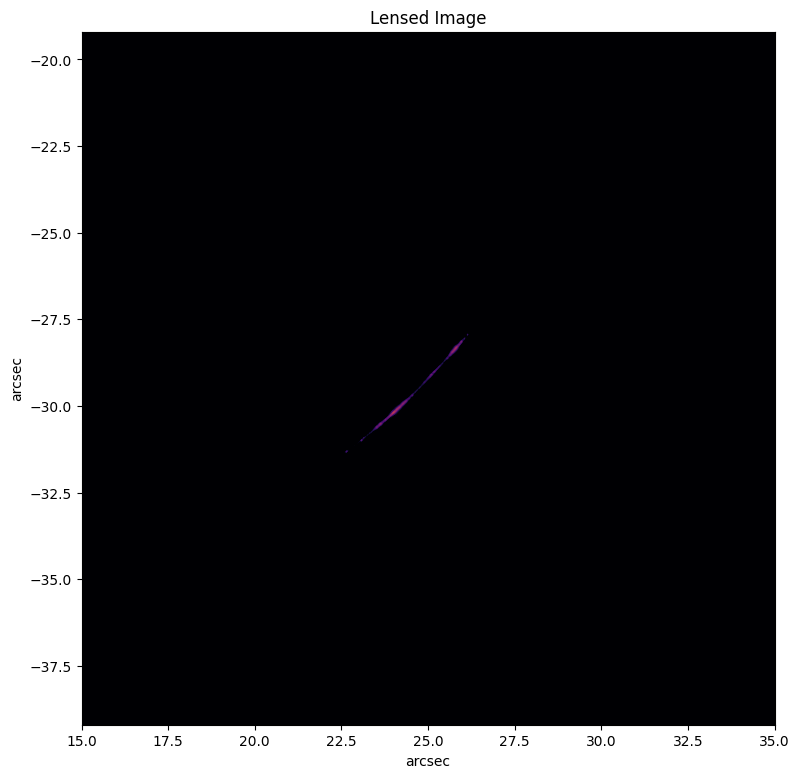

In [25]:
from astropy.convolution import convolve, AiryDisk2DKernel

air_pix = 0.05/detector_arcsec_per_pxl
convolved_image = convolve(image, AiryDisk2DKernel(air_pix),fill_value=0,nan_treatment='fill')
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plot_image(convolved_image,image_center,reco_image_fov,ax,"Lensed Image")
# ax.set_xlim([22.5,27.5])
# ax.set_ylim([-32.5,-27.5])

In [7]:
%%time
i,j = 200,200

top_left = traced_image_plane_corners_native[i,j]

y = source_plane_native[:,0,0]
x = source_plane_native[0,:,1]

if not source_plane_box.contains(Point(top_left[1],top_left[0])): 
    luminosity = 0 
else:
    top_right = traced_image_plane_corners_native[i+1,j]
    bottom_right = traced_image_plane_corners_native[i+1,j+1]
    bottom_left = traced_image_plane_corners_native[i,j+1]

    vertices = [top_left,top_right,bottom_right,bottom_left]

    traced_pixel = prep(Polygon(vertices))

    # compute bounding box
    x_min = min([v[1] for v in vertices])
    y_min = min([v[0] for v in vertices])
    x_max = max([v[1] for v in vertices])
    y_max = max([v[0] for v in vertices])
    bounding_box = Polygon(([x_min,y_min],[x_min,y_max],[x_max,y_max],[x_max,y_min]))

    y_index_range = [np.where(y-y_max > 0, y-y_max, np.inf).argmin(),np.where(y_min-y > 0, y_min-y, np.inf).argmin()]
    x_index_range = [np.where(x_min-x > 0, x_min-x, np.inf).argmin(),np.where(x-x_max > 0, x-x_max, np.inf).argmin()]

    image_slice = galaxy_image_native[y_index_range[0]:y_index_range[1]+1,x_index_range[0]:x_index_range[1]+1]
    source_plane_slice = source_plane_native[y_index_range[0]:y_index_range[1]+1,x_index_range[0]:x_index_range[1]+1]
    source_points = np.stack((source_plane_slice[:,:,0],source_plane_slice[:,:,1],image_slice))
    if source_points.size == 0:
        luminosity = 0
    else:
        source_points = np.swapaxes(source_points,0,2)
        source_points = shapely.points(np.concatenate(source_points))

        source_pixels = []
        source_pixels.extend(filter(traced_pixel.contains,source_points))
        luminosity = 0 if len(source_pixels) == 0 else np.mean([p.z for p in source_pixels])

CPU times: user 15.4 ms, sys: 3.83 ms, total: 19.3 ms
Wall time: 20.5 ms
